In [1]:
from bioinfokit import visuz
import pandas as pd
import numpy as np
import csv
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
import math
from scipy import stats

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# load data
data = pd.read_csv('../data/pos_data.csv')

In [24]:
# load design file
design = pd.read_csv('../data/pos_design_HumanVSBovine.csv')

In [25]:
# data_ref = pd.read_csv('../results/R_outputs/pos_100_withbg_ready.csv')

In [26]:
data.head()

,row ID,row m/z,row retention time,row identity,row comment,row number of detected peaks,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak height,QE2_jdg_242_

In [27]:
pd.isnull(data["row identity"].iloc[3])

False

In [28]:
def add_label(row):
    if pd.isnull(row["row identity"]):
        return str(round(row["row m/z"],2)) + "/" + str(round(row["row retention time"], 2))
    else:
        return row["row identity"]

In [29]:
data['label'] = data.apply(lambda row: add_label(row), axis = 1)

In [30]:
design.head()

,sampleID,group
0,QE2_jdg_242_Lemas_1[Blank]p.mzXML Peak height,zero-blank
1,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak height,zero-blank
2,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak height,zero-blank
3,QE2_jdg_242_Lemas_4[Blank]p.mzXML Peak height,zero-blank
4,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak height,zero-blank


In [31]:
a = list(set(design['group']))

In [32]:
a.sort()

In [33]:
a

['bovine', 'human', 'zero-blank']

In [34]:
blank_group_name = "zero-blank"
group1_name = "bovine"
group2_name = "human"
ratio_bar = 100

In [35]:
group1_columns = design[design.group == group1_name].sampleID.tolist()
group2_columns = design[design.group == group2_name].sampleID.tolist()
blank_columns = design[design.group == blank_group_name].sampleID.tolist()

In [36]:
def add_threshold(row, names):
    value = np.mean(row[names]) + 3*np.std(row[names])
    return value if value >0 else 5000 

In [37]:
def blank_subtraction(row, name_group, name_threshold, bar):
    return (np.mean(row[name_group]) - row[name_threshold])/row[name_threshold] > bar

In [38]:
def add_pvalue(row, left_names, right_names):
    t, p = stats.ttest_ind(row[left_names], row[right_names])
    return p

In [39]:
def fold_change(row, left, right):
    if row[right] == 0:
        return np.inf
    elif row[left] == 0:
        return -np.inf
    else:
        result = row[left]/row[right]
        return result if result >=1 else -1/result

In [40]:
data['threshold'] = data.apply(lambda row: add_threshold(row, blank_columns), axis = 1)

In [41]:
data['group1_selected'] = data.apply(lambda row: blank_subtraction(row, group1_columns, "threshold", ratio_bar), axis = 1)

In [42]:
data['group2_selected'] = data.apply(lambda row: blank_subtraction(row, group2_columns, "threshold", ratio_bar), axis = 1)

In [43]:
data['group1_mean'] = data[group1_columns].mean(axis = 1)

In [44]:
data['group2_mean'] = data[group2_columns].mean(axis = 1)

In [45]:
data['fold_change'] = data.apply(lambda row: fold_change(row, "group1_mean", "group2_mean"), axis = 1)

In [46]:
data['p_value'] = data.apply(lambda row: add_pvalue(row, group1_columns, group2_columns), axis = 1)

In [47]:
len(data[data.group1_selected == 1])

515

In [48]:
len(data[data.group2_selected == 1])

448

In [49]:
data_withBS = data[(data.group1_selected == 1) | (data.group2_selected == 1)]

In [50]:
check = data[data["row ID"] == 2598]

In [51]:
(np.mean(check[group1_columns].iloc[0]) - check['threshold'].iloc[0])/check['threshold']

2307    0.636861
Name: threshold, dtype: float64

In [52]:
len(data_withBS)

677

In [53]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [54]:
data_withBS.head()

,row ID,row m/z,row retention time,row identity,row comment,row number of detected peaks,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_2[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_7[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_5[Blank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak status,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_8[Blank]p.mzXML Peak height,QE2_jdg_242_

### Two-sample comparison

In [55]:
import copy

In [56]:
data_withBS_filtered = copy.deepcopy(data_withBS)

In [57]:
data_withBS_filtered = data_withBS_filtered.sort_values(by = "p_value").iloc[0:50]

In [58]:
data_withBS_filtered.index = data_withBS_filtered.label

In [59]:
data_withBS_filtered = data_withBS_filtered[group1_columns + group2_columns]

In [60]:
data_withBS_filtered.head()

,QE2_jdg_242_Lemas_11[LAB_11]p.mzXML Peak height,QE2_jdg_242_Lemas_12[LAB_12]p.mzXML Peak height,QE2_jdg_242_Lemas_13[LAB_13]p.mzXML Peak height,QE2_jdg_242_Lemas_14[LAB_14]p.mzXML Peak height,QE2_jdg_242_Lemas_15[LAB_15]p.mzXML Peak height,QE2_jdg_242_Lemas_16[LAB_16]p.mzXML Peak height,QE2_jdg_242_Lemas_17[LAB_17]p.mzXML Peak height,QE2_jdg_242_Lemas_18[LAB_18]p.mzXML Peak height,QE2_jdg_242_Lemas_19[LAB_19]p.mzXML Peak height,QE2_jdg_242_Lemas_20[LAB_20]p.mzXML Peak height,QE2_jdg_242_Lemas_1[LAB_01]p.mzXML Peak height,QE2_jdg_242_Lemas_2[LAB_02]p.mzXML Peak height,QE2_jdg_242_Lemas_3[LAB_03]p.mzXML Peak height,QE2_jdg_242_Lemas_4[LAB_04]p.mzXML Peak height,QE2_jdg_242_Lemas_5[LAB_05]p.mzXML Peak height,QE2_jdg_242_Lemas_6[LAB_06]p.mzXML Peak height,QE2_jdg_242_Lemas_7[LAB_07]p.mzXML Peak height,QE2_jdg_242_Lemas_8[LAB_08]p.mzXML Peak height,QE2_jdg_242_Lemas_9[LAB_09]p.mzXML Peak height,QE2_jdg_242_Lemas_10[LAB_10]p.mzXML Peak height
label,,,,,,,,,,,,,,,,,,,,
136.51/1.18,8.449432e+05,8.455345e+05,7.877386e+05,8.874775e+05,9.412424e+05,8.216571e+05,9.219635e+05,8.794872e+05,9.070058e+05,9.537527e+05,26663.644531,0.000000e+00,19573.500000,9950.214844,5.015580e+03,5967.429688,17833.302734,0.000000e+00,9305.142578,6328.911133
186.11/2.4,2.367593e+07,2.224077e+07,2.385426e+07,2.365834e+07,2.553909e+07,2.134026e+07,2.518781e+07,2.562386e+07,2.426229e+07,2.616668e+07,787523.851786,1.106095e+06,488669.883036,444814.903571,2.553825e+06,666714.782143,604895.851786,2.144380e+06,237666.078125,447350.906250
208.04/7.99,1.051467e+06,1.070265e+06,1.119753e+06,1.242880e+06,1.053426e+06,1.208796e+06,1.051081e+06,1.185702e+06,1.044025e+06,1.106197e+06,0.000000,0.000000e+00,18740.560547,24020.375000,3.869608e+04,76734.921875,40119.898438,0.000000e+00,112221.507812,28363.794922
205.52/1.18,8.780025e+05,8.791650e+05,9.905880e+05,9.802132e+05,9.593819e+05,7.082011e+05,7.871532e+05,9.213586e+05,8.559283e+05,8.486902e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
185.0/1.18,5.642436e+05,5.079057e+05,4.853424e+05,6.170960e+05,5.800599e+05,4.399245e+05,5.841933e+05,5.346090e+05,5.931513e+05,5.176426e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [61]:
for i, group1_column in enumerate(group1_columns):
    data_withBS_filtered.rename(columns = {group1_column: group1_name + '_' + str(i)}, inplace = True)
for i, group2_column in enumerate(group2_columns):
    data_withBS_filtered.rename(columns = {group2_column: group2_name + '_' + str(i)}, inplace = True)

In [62]:
data_withBS_filtered.head()

,bovine_0,bovine_1,bovine_2,bovine_3,bovine_4,bovine_5,bovine_6,bovine_7,bovine_8,bovine_9,human_0,human_1,human_2,human_3,human_4,human_5,human_6,human_7,human_8,human_9
label,,,,,,,,,,,,,,,,,,,,
136.51/1.18,8.449432e+05,8.455345e+05,7.877386e+05,8.874775e+05,9.412424e+05,8.216571e+05,9.219635e+05,8.794872e+05,9.070058e+05,9.537527e+05,26663.644531,0.000000e+00,19573.500000,9950.214844,5.015580e+03,5967.429688,17833.302734,0.000000e+00,9305.142578,6328.911133
186.11/2.4,2.367593e+07,2.224077e+07,2.385426e+07,2.365834e+07,2.553909e+07,2.134026e+07,2.518781e+07,2.562386e+07,2.426229e+07,2.616668e+07,787523.851786,1.106095e+06,488669.883036,444814.903571,2.553825e+06,666714.782143,604895.851786,2.144380e+06,237666.078125,447350.906250
208.04/7.99,1.051467e+06,1.070265e+06,1.119753e+06,1.242880e+06,1.053426e+06,1.208796e+06,1.051081e+06,1.185702e+06,1.044025e+06,1.106197e+06,0.000000,0.000000e+00,18740.560547,24020.375000,3.869608e+04,76734.921875,40119.898438,0.000000e+00,112221.507812,28363.794922
205.52/1.18,8.780025e+05,8.791650e+05,9.905880e+05,9.802132e+05,9.593819e+05,7.082011e+05,7.871532e+05,9.213586e+05,8.559283e+05,8.486902e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
185.0/1.18,5.642436e+05,5.079057e+05,4.853424e+05,6.170960e+05,5.800599e+05,4.399245e+05,5.841933e+05,5.346090e+05,5.931513e+05,5.176426e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000


### Hierachical Clustering

In [120]:
import seaborn as sns; sns.set(color_codes=True)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

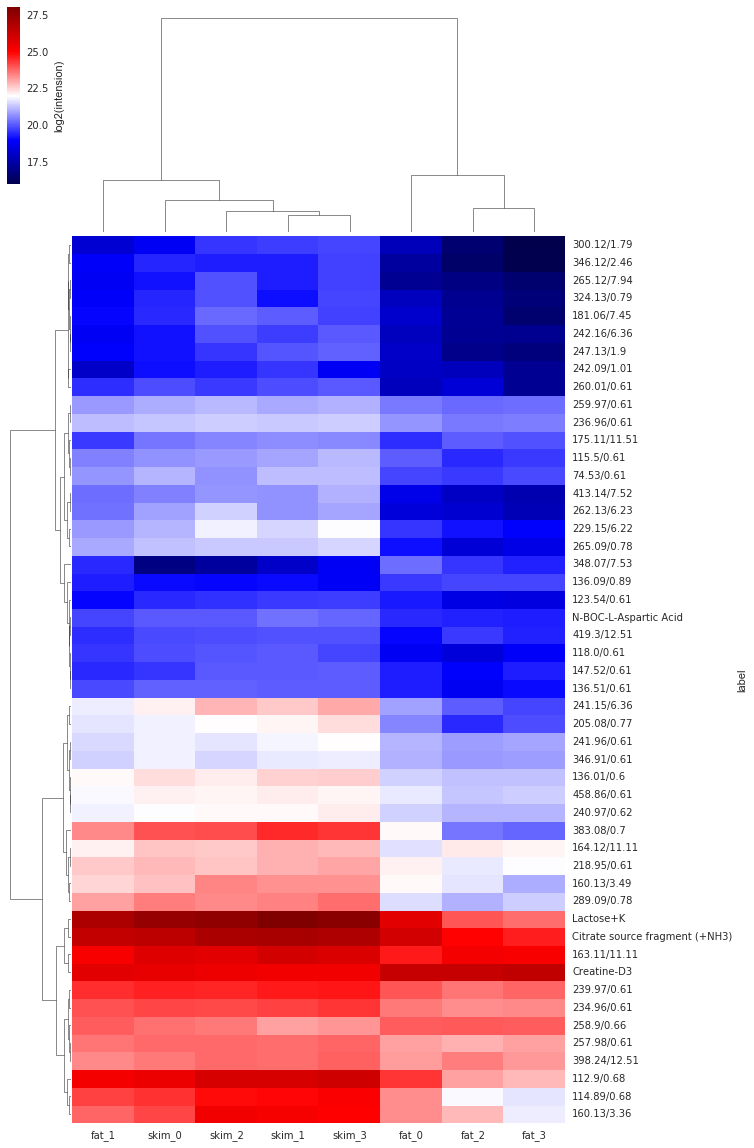

In [126]:
g = sns.clustermap(np.log2(data_withBS_filtered + 1), figsize = (10, 20), xticklabels=True, yticklabels=True, cmap = "seismic", cbar_kws={'label': 'log2(intension)'}, method = 'ward')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

In [127]:
g.savefig("test.png")

### PCA

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [64]:
# Plot PCA with confidence ellipse

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    
    See how and why this works: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    
    This function has made it into the matplotlib examples collection:
    https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    
    Or, once matplotlib 3.1 has been released:
    https://matplotlib.org/gallery/index.html#statistics
    
    I update this gist according to the version there, because thanks to the matplotlib community
    the code has improved quite a bit.
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
#    return ellipse
    return ax.add_patch(ellipse)

In [65]:
x = data_withBS_filtered.as_matrix().T
x = StandardScaler().fit_transform(x)

In [66]:
pca = PCA(n_components=min(x.shape))
principalComponents = pca.fit_transform(x)
columns_components = []
for i in range(pca.n_components_):
    columns_components.append('principal component ' + str(i+1))

In [67]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns_components)

In [70]:
target_data = {"label": [group1_name] * len(group1_columns) + [group2_name] * len(group2_columns)}

In [71]:
target_df = pd.DataFrame(target_data)

In [72]:
final_df = pd.concat([principalDf, target_df.label], axis = 1)

In [73]:
final_df

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,label
0,5.864999,-0.644361,-1.185602,0.081767,-0.170186,0.317127,-0.380223,0.236875,-0.247867,0.342079,0.259399,0.170974,0.175059,-0.011540,-0.012495,-0.043786,0.021850,0.016119,0.008695,5.005534e-16,bovine
1,5.928160,-0.130078,-0.123636,-0.416952,1.143982,0.189316,-0.527909,-0.350425,0.246610,-0.051373,-0.154474,-0.219762,0.141374,-0.034624,-0.000687,-0.042404,-0.009378,0.010220,-0.002368,5.005534e-16,bovine
2,6.743264,-1.452829,-0.181516,1.045888,-0.129171,-0.325279,-0.038583,-0.418705,-0.271216,-0.213319,-0.143416,-0.011328,-0.111793,-0.001784,0.020433,0.009528,0.005088,-0.010436,-0.010635,5.005534e-16,bovine
3,8.058075,0.849833,-0.769070,-0.537191,0.013542,0.250612,0.767228,-0.174340,-0.530108,0.027502,-0.129001,-0.139217,-0.039342,0.034791,0.008815,0.031657,-0.030367,-0.014253,0.000256,5.005534e-16,bovine
4,7.391651,-0.306411,-0.619739,-0.386560,-0.864419,0.216014,0.078035,-0.031129,0.703103,-0.139873,0.149515,-0.151259,-0.115885,-0.016417,0.012282,0.036015,0.000390,-0.002929,-0.006067,5.005534e-16,bovine
5,6.802471,1.603451,-0.321816,1.200224,0.422183,-0.147515,0.075497,0.330500,0.246194,-0.098301,0.069713,0.018679,-0.008830,0.007940,0.003949,-0.008536,0.007756,-0.002443,-0.002549,5.005534e-16,bovine
6,6.886879,0.579603,1.370575,0.156605,-0.570095,0.959828,-0.383330,-0.137655,-0.179466,-0.071835,-0.033268,0.075860,0.036392,-0.013873,0.000592,-0.002981,0.005761,-0.005301,0.001377,5.005534e-16,bovine
7,8.174390,0.306100,0.457483,-0.400419,-0.003924,-0.658463,0.297572,-0.416602,0.240130,0.231097,-0.048025,0.396259,-0.001579,-0.020614,-0.028033,-0.028186,0.011332,0.012340,0.010081,5.005534e-16,bovine
8,6.661797,-0.629922,0.723545,-0.000943,-0.169571,-0.339061,0.084243,0.619628,0.062741,0.338189,-0.357888,-0.188014,0.071970,0.032270,-0.001795,0.035372,-0.017341,0.002160,0.005337,5.005534e-16,bovine
9,6.801873,-0.424349,0.641486,-0.627272,0.483038,-0.340043,-0.052740,0.402561,-0.254751,-0.355967,0.409867,0.030408,-0.113467,0.022774,-0.000795,0.008265,0.010347,-0.003254,-0.003350,5.005534e-16,bovine


In [74]:
x_group1 = final_df[final_df.label == group1_name]["principal component 1"].as_matrix()
y_group1 = final_df[final_df.label == group1_name]["principal component 2"].as_matrix()
x_group2 = final_df[final_df.label == group2_name]["principal component 1"].as_matrix()
y_group2 = final_df[final_df.label == group2_name]["principal component 2"].as_matrix()

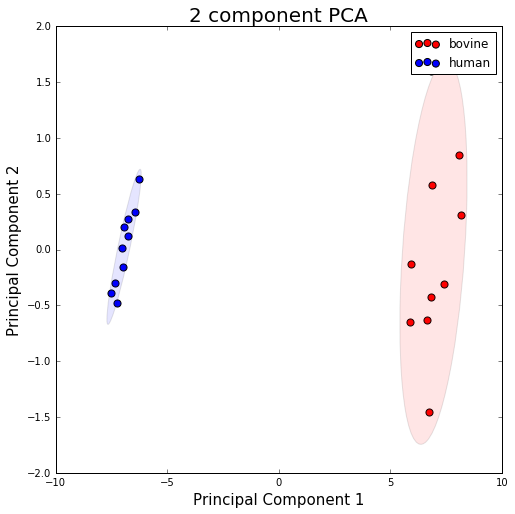

In [75]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [group1_name, group2_name]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['label'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
# ax.set_xlim(-50, 50)
# ax.set_ylim(-50, 50)
confidence_ellipse(x_group1, y_group1, ax, n_std = 1.96, facecolor = "r", alpha = 0.1)
confidence_ellipse(x_group2, y_group2, ax, n_std = 1.96, facecolor = "b", alpha = 0.1)
ax.grid()

## PLS-DA

In [58]:
from sklearn.cross_decomposition import PLSRegression

In [42]:
data_withBS_filtered.head()

,fat_0,fat_1,fat_2,fat_3,skim_0,skim_1,skim_2,skim_3
label,,,,,,,,
PHOSPHOCHOLINE,7.172997e+08,1.407830e+09,5.269804e+08,4.318398e+08,1.506514e+09,1.317603e+09,8.507828e+08,1.121725e+09
Glycerophosphocholine,4.594217e+08,7.791556e+08,3.869271e+08,2.544940e+08,8.114799e+08,7.673914e+08,6.673932e+08,7.154476e+08
L-CARNITINE,4.691478e+08,7.961944e+08,3.046261e+08,2.121236e+08,8.994626e+08,9.883137e+08,7.963888e+08,7.219592e+08
204.12/5.49,7.869766e+07,8.456591e+07,6.879737e+07,0.000000e+00,9.363446e+07,1.159167e+08,1.388494e+08,1.110957e+08
204.12/5.55,7.661319e+07,8.444182e+07,6.864606e+07,5.289199e+07,9.511251e+07,1.037598e+08,1.209267e+08,9.832158e+07


In [46]:
data_withBS_filtered.reset_index(drop = True, inplace = True)

In [47]:
data_withBS_filtered.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828
fat_0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,4.951844e+07,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.000000e+00,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.1

In [52]:
data_withBS_filtered = data_withBS_filtered.T

In [54]:
data_withBS_filtered["label"] = data_withBS_filtered.index

In [55]:
data_withBS_filtered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,label
fat_0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,49518440.00,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.0,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.115857e+0

In [56]:
data_withBS_filtered.reset_index(drop = True, inplace = True)

In [57]:
data_withBS_filtered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,label
0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,49518440.00,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.0,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.115857e+06,6.

In [62]:
y = np.array(data_withBS_filtered.label)

In [69]:
y

array(['fat_0', 'fat_1', 'fat_2', 'fat_3', 'skim_0', 'skim_1', 'skim_2',
       'skim_3'], dtype=object)

In [71]:
y[0:4] = 0

In [72]:
y[4:] = 1

In [66]:
X = data_withBS_filtered.loc[:, data_withBS_filtered.columns != "label"].values

In [67]:
plsr = PLSRegression(n_components=2, scale=False)

In [74]:
plsr.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=False, tol=1e-06)

In [78]:
colorlist = ['r', 'r', 'r', 'r', 'b', 'b', 'b', 'b']

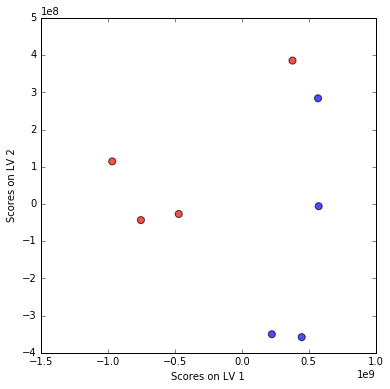

In [79]:
scores = pd.DataFrame(plsr.x_scores_)
scores.index=data_withBS_filtered.index

ax = scores.plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, 
                 c=colorlist, figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')